In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
from transformers import ViTForImageClassification

In [2]:
dataset = load_dataset("e1010101/tongue-images-384")

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [3]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

In [4]:
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

In [5]:
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

In [7]:
model = ViTForImageClassification.from_pretrained('e1010101/vit-384-tongue-image')

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

In [8]:
def reshape_transform_vit_huggingface(x):
    # Remove the class token
    activations = x[:, 1:, :]
    
    # Compute grid size dynamically
    grid_size = int(activations.shape[1] ** 0.5)
    
    # Reshape to [batch_size, grid_size, grid_size, hidden_dim]
    activations = activations.view(activations.shape[0], grid_size, grid_size, -1)
    
    # Rearrange dimensions to [batch_size, hidden_dim, grid_size, grid_size]
    activations = activations.permute(0, 3, 1, 2)
    return activations

In [12]:
image = Image.open("../Samples/sample_5.jpg")

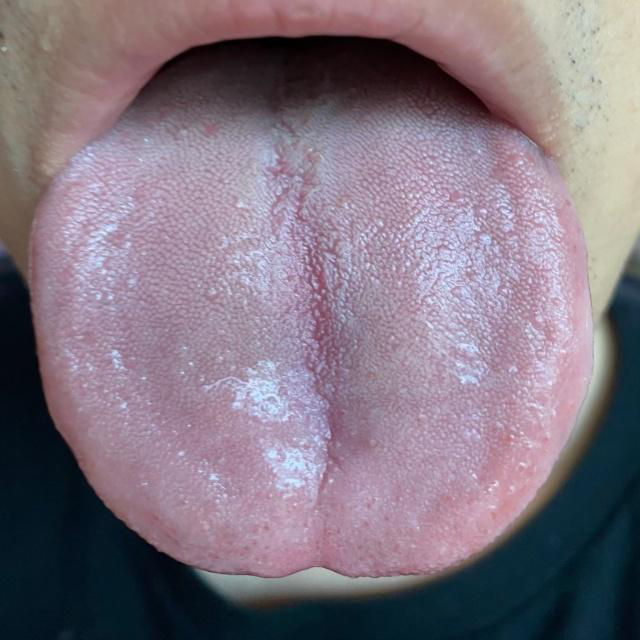

In [13]:
image

In [14]:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Crack")),
                       ClassifierOutputTarget(category_name_to_index(model, "Red-Dots")),
                       ClassifierOutputTarget(category_name_to_index(model, "Toothmark"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)

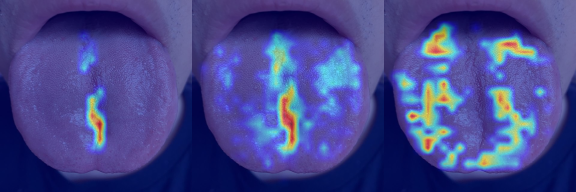

In [17]:
# Crack, Red Dots, Toothmark
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)))

In [18]:
pred = model(tensor_resized.unsqueeze(0))
pred = torch.nn.functional.softmax(pred.logits, dim=1)
pred

tensor([[0.0396, 0.9548, 0.0055]], grad_fn=<SoftmaxBackward0>)